In [1]:
import torch.nn as nn
import torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from data.dataloader import data_generator
from training.optimizer import get_optimizer
from models.losses import loss_function
from models.utils import eigen_decomp

In [4]:
from models.gru_denoiser import BiGRUSpectralDenoiser

à evoquer calcul dans GRU :
$$\hat{\Sigma} = \hat{Q} \hat{\Lambda} \hat{Q}^T$$

$$\tilde{\Sigma}_{NN} = \hat{Q} \tilde{\Lambda}_{NN} \hat{Q}^T$$

## NN

In [23]:
model = BiGRUSpectralDenoiser(hidden_size=64) # hidden_size to be tunned

### Training loop

On pourra rajouter dans la loss un terme pour comparer les valeurs propres/les matrices totals par exemples des matrices.

On pourrait calculer la loss par epochs d'une tailles plus petites ou même aléatoire

In [24]:
losses = []

In [25]:
N_min=80
N_max=300
T_min=80
T_max=200

In [26]:
optimizer = get_optimizer(model)

In [ ]:
# batch are full for now
batch_size = 128 # to be tunned 256 would be better but slow... the bigger the better because my universe of data is huge
epochs = 250 # approximately (tunned)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    lam_emp, Q_emp, Sigma_true, T = next(data_generator(batch_size, N_min=N_min, N_max=N_max, T_min=T_min, T_max=T_max))
    lam_pred = model(lam_emp)  # forward pass through the NN (GRU+fc)

    # compute losses
    loss = loss_function(lam_pred, Q_emp, Sigma_true, T)

    # backprop
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # very noisy optimization we could lower lr as loss deacreases
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} — loss: {loss.item():.6f}")


Epoch 1/250 — loss: 0.054148
Epoch 2/250 — loss: 0.038628
Epoch 3/250 — loss: 0.066777
Epoch 4/250 — loss: 0.062406
Epoch 5/250 — loss: 0.063981
Epoch 6/250 — loss: 0.052450
Epoch 7/250 — loss: 0.063057
Epoch 8/250 — loss: 0.052237
Epoch 9/250 — loss: 0.034500
Epoch 10/250 — loss: 0.045819
Epoch 11/250 — loss: 0.049418
Epoch 12/250 — loss: 0.096741
Epoch 13/250 — loss: 0.036158
Epoch 14/250 — loss: 0.065943
Epoch 15/250 — loss: 0.075857
Epoch 16/250 — loss: 0.138264
Epoch 17/250 — loss: 0.102848
Epoch 18/250 — loss: 0.050223
Epoch 19/250 — loss: 0.060727
Epoch 20/250 — loss: 0.067492
Epoch 21/250 — loss: 0.049062
Epoch 22/250 — loss: 0.075230
Epoch 23/250 — loss: 0.051039
Epoch 24/250 — loss: 0.044153
Epoch 25/250 — loss: 0.093378
Epoch 26/250 — loss: 0.030184
Epoch 27/250 — loss: 0.053991
Epoch 28/250 — loss: 0.032385
Epoch 29/250 — loss: 0.127313
Epoch 30/250 — loss: 0.043395
Epoch 31/250 — loss: 0.034011
Epoch 32/250 — loss: 0.042499
Epoch 33/250 — loss: 0.104797
Epoch 34/250 — loss

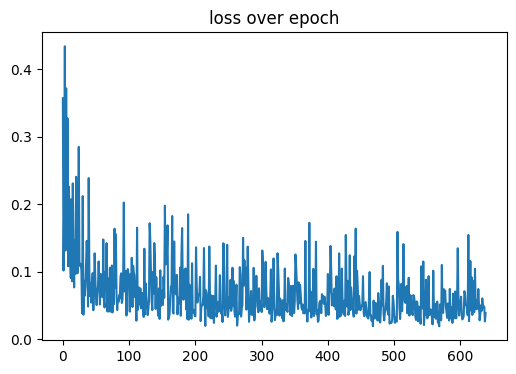

In [31]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("loss over epoch")
plt.savefig("images/training_loss.png")
plt.show()

might go up and down because it really depends on the N and T randomly picked.

we have to stop after the slow down of deacrese. otherwise we might face overfitting

### out of sample comparaison 1

In [32]:
batch_size_oos_1 = 25
N_list_test_1 = [20, 40, 60, 80, 100, 120, 140, 160, 180,200,220]
T_list_test_1 = [20, 40,60, 80, 100, 120, 150, 180, 200, 220, 240, 260, 280, 300]

In [33]:
losses_value = []

In [34]:
for n in N_list_test_1:
    for t in T_list_test_1:
        lam_emp_oos_i, Q_emp_oos_i, Sigma_true_oos_i, T_t = next(data_generator(batch_size_oos_1, N_min=n, N_max=n, T_min=t, T_max=t))
        lam_pred_test_i = model(lam_emp_oos_i)
        losses_value.append(loss_function(lam_pred_test_i, Q_emp_oos_i, Sigma_true_oos_i, T_t).item())

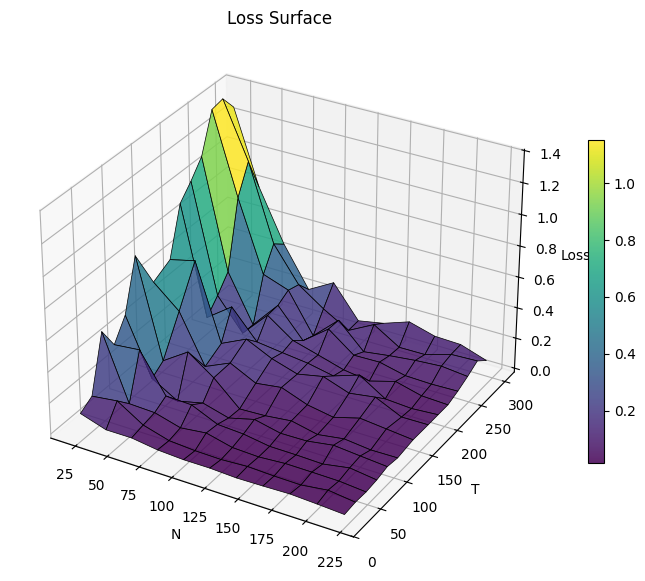

In [35]:
# meshing
loss_grid = np.array(losses_value).reshape(len(np.array(N_list_test_1)), len(np.array(T_list_test_1)))
N_mesh, T_mesh = np.meshgrid(np.array(N_list_test_1), np.array(T_list_test_1), indexing='ij')

# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_mesh, T_mesh, loss_grid,
                       cmap='viridis',
                       edgecolor='k',
                       linewidth=0.5,
                       alpha=0.85)

ax.set_xlabel("N")
ax.set_ylabel("T")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

fig.colorbar(surf, shrink=0.6)
plt.savefig('images/loss_surface.png')
plt.show()

### out of sample comparaison 2

In [36]:
batch_size_oos = 1024

In [37]:
lam_emp_oos, Q_emp_oos, Sigma_true_oos, T = next(data_generator(batch_size_oos, N_min=200, N_max=200, T_min=100, T_max=100))


In [38]:
lam_pred_test = model(lam_emp_oos)

Comparaison eigenvalues $\lambda$

In [39]:
# mse
mse = nn.MSELoss()

In [40]:
lam_true_oos = torch.tensor(np.array([eigen_decomp(Sigma.numpy())[0] for Sigma in Sigma_true_oos]), dtype=torch.float32)


mse_pred_test_lam  = mse(lam_pred_test, lam_true_oos)
mse_noisy_test_lam = mse(lam_true_oos, lam_emp_oos.squeeze(-1))

print(f"MSE cleaned: {mse_pred_test_lam:.6f}")
print(f"MSE noisy  : {mse_noisy_test_lam:.6f}")


MSE cleaned: 0.042607
MSE noisy  : 2096.281006


Comparaison Trace

In [41]:
trace_true_test = lam_true_oos.sum(dim=1).mean()
trace_pred_test = lam_pred_test.sum(dim=1).mean()
trace_noisy_test = lam_emp_oos.sum(dim=1).mean()

mse_tr_test_pred = mse(trace_true_test,trace_pred_test)
mse_tr_test_noisy = mse(trace_true_test,trace_noisy_test)

print(f"Real Trace : {trace_true_test:.4f}, predicted : {trace_pred_test:.4f}, noisy : {trace_noisy_test:.4f}")

print(f"MSE tr noisy  : {mse_tr_test_noisy:.6f}")
print(f"MSE tr cleaned: {mse_tr_test_pred:.6f}")

Real Trace : 54.7929, predicted : 57.4072, noisy : 936.9535
MSE tr noisy  : 778207.312500
MSE tr cleaned: 6.834304


*10^6 fois mieux

Comparaison matrix $\Sigma$

In [42]:
def reconstruct_cov(Q, lam):
    Lambda = torch.diag_embed(lam.squeeze(-1))
    Sigma = Q @ Lambda @ Q.transpose(1, 2)
    return Sigma

In [43]:
Sigma_true_test = Sigma_true_oos
Sigma_noisy_test = reconstruct_cov(Q_emp_oos, lam_emp_oos)
Sigma_pred_test   = reconstruct_cov(Q_emp_oos, lam_pred_test)

fro_noisy_test_mat = mse(Sigma_noisy_test, Sigma_true_test)
fro_pred_test_mat   = mse(Sigma_pred_test, Sigma_true_test)

print(f"mse error (noisy):  {fro_noisy_test_mat:.6f}")
print(f"mse error (GRU)  :  {fro_pred_test_mat:.6f}")

mse error (noisy):  10.506650
mse error (GRU)  :  0.000311


supérieur à *10^6 fois mieux

Graphique : 

In [44]:
pairs = ['Matrix', 'Trace', 'EigenValues']
mse_noisy   = [fro_noisy_test_mat.item(), mse_tr_test_noisy.item(), mse_noisy_test_lam.item()]
mse_cleaned = [fro_pred_test_mat.item(), mse_tr_test_pred.item(), mse_pred_test_lam.item()]

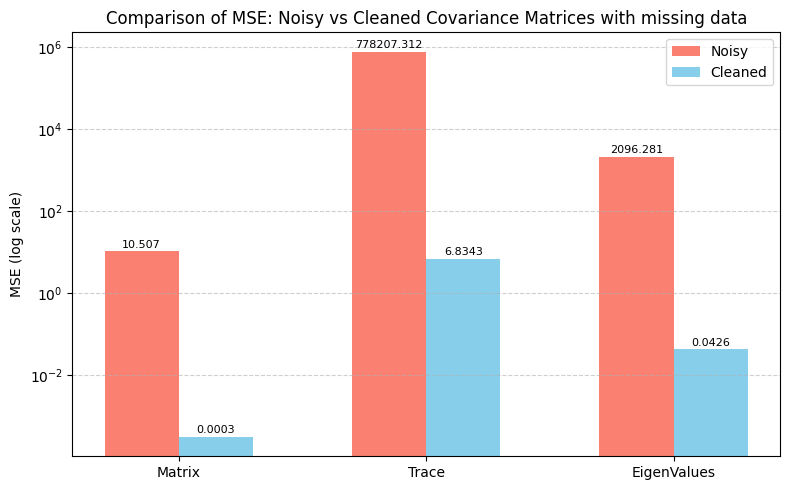

In [45]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(pairs))
width = 0.3

plt.figure(figsize=(8,5))
plt.bar(x - width/2, mse_noisy, width, label='Noisy', color='salmon')
plt.bar(x + width/2, mse_cleaned, width, label='Cleaned', color='skyblue')

plt.yscale('log')
plt.ylabel('MSE (log scale)')
plt.xticks(x, pairs)
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)

for i, (n, c) in enumerate(zip(mse_noisy, mse_cleaned)):
    plt.text(x[i] - width/2, n*1.1, f"{n:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + width/2, c*1.1, f"{c:.4f}", ha='center', va='bottom', fontsize=8)

plt.title('Comparison of MSE: Noisy vs Cleaned Covariance Matrices with missing data')
plt.tight_layout()
plt.savefig('images/results_NN_oos')
plt.show()


### Add comparaison

#### Comparaison with no missing value

#### Comparaison with RIE estimator on no missing value

### Add hyperparameter selection

### Loss that minimizes the Portfolio Risk

Week timeline : 
- remove comparaison with trace : if necessary it can be normalized at the output of our network
- remove comparaison with eigenvalues : not meaning full as they are in another base !
- use the naiv estimator
- comparaison between GRU estimator and naiv estim
- comparaison between GRU estimator and the one from shaffer's book
- provide the GRU with x_i = {l_i, T} => find a way to give it the mask without making it dependant on some size

To be added
- we could add : eigenvalues monotonically decreasing
- hyperparameter tuning
- k split cross validation
- try stochastic gradient descent

To be written in the report
- write abt RIE and that we do smt simular
- write abt GRU and how it helps us here
- a problem is that eigenVector are noisy